In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from TPE import train_best_dgm_model, train_best_mim_model
from main import train_heat
import optuna

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spatial_dims = 2

In [ ]:
best_heat_dgm = optuna.load_study(study_name=f"DGM Heat {spatial_dims}D", storage="sqlite:///dgm_heat.db")
dgm, dgm_best_loss, dgm_stats = train_best_dgm_model(best_heat_dgm, spatial_dims, 300)
dgm_stats

In [ ]:
best_heat_mim = optuna.load_study(study_name=f"MIM Heat {spatial_dims}D", storage="sqlite:///mim_heat.db")
mim, mim_best_loss, mim_stats = train_best_mim_model(best_heat_mim, spatial_dims, 300)
mim_stats

In [ ]:
dgm, mim = train_heat(spatial_dims, 300)

In [ ]:
def gen_heat_snapshots(model, grid_size=100, time_steps=[0.1, 0.25, 0.5, 0.9]):
    import torch
    import matplotlib.pyplot as plt
    import numpy as np

    # Define the grid size and spatial coordinates
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

    # Convert spatial grid to torch tensor
    grid_tensor = torch.tensor(grid_points).float().to(DEVICE)

    # Precompute time tensors for the specified time steps
    time_tensors = [torch.full((grid_tensor.shape[0], 1), t, device=DEVICE) for t in time_steps]

    # Create subplots for the snapshots
    fig, axes = plt.subplots(1, len(time_steps), figsize=(15, 5), constrained_layout=True)
    if len(time_steps) == 1:  # Handle case for a single time step
        axes = [axes]

    for i, (ax, time_tensor, t) in enumerate(zip(axes, time_tensors, time_steps)):
        with torch.no_grad():
            output = model(grid_tensor, time_tensor)
            if isinstance(output, tuple):
                output = output[0]
        solution = output.cpu().numpy().reshape(grid_size, grid_size)
        
        # Plot the solution
        im = ax.imshow(solution, extent=(0, 1, 0, 1), origin="lower", cmap="hot", vmin=-1, vmax=1)
        ax.set_title(f"t = {t:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, label="Temperature")

    # Show the plot
    plt.suptitle("Stochastic Heat Equation Snapshots")
    plt.show()


In [ ]:
dgm_heat_ani = gen_heat_ani(dgm)
dgm_heat_ani.save("dgm_heat_ani.gif", writer="imagemagick", fps=10)
print("DGM Heat Equation Animation")
# HTML(dgm_heat_ani.to_jshtml())

In [ ]:
mim_heat_ani = gen_heat_ani(mim)
mim_heat_ani.save("mim_heat_ani.gif", writer="imagemagick", fps=10)
print("MIM Heat Equation Animation")
# HTML(mim_heat_ani.to_jshtml())

In [5]:
def det_answer(grid_points, t):
    # Ensure tensors are on the same device
    grid_points = grid_points.to(t.device)
    
    # Extract x and y coordinates
    x, y = grid_points[:, 0], grid_points[:, 1]
    
    # Handle batch dimension for t (assume it's of shape [batch_size] or [1])
    t = t.view(-1)[0]  # Flatten t and extract the first element if batched
    
    # Compute the analytical solution
    return torch.exp(-np.pi**2 * t * 0.1) * torch.cos(np.pi * x) * torch.cos(np.pi * y)

MovieWriter imagemagick unavailable; using Pillow instead.


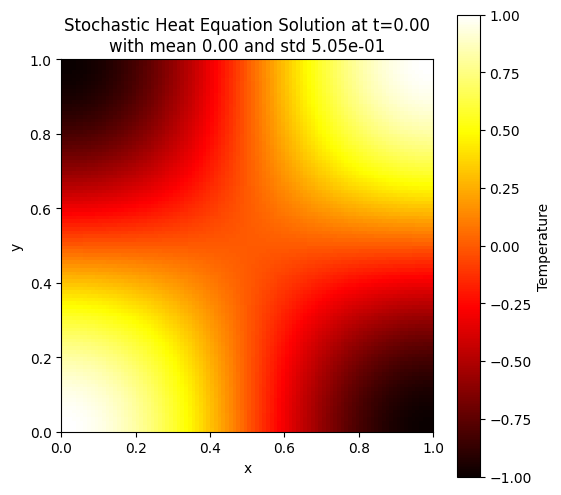

In [6]:
det_ani = gen_heat_ani(det_answer, grid_size=100, n_time_steps=100)
det_ani.save("det_ani.gif", writer="imagemagick", fps=10)